In [ ]:
import cv2 

img = cv2.imread('/home/likcos/DataSets/sportimages/sportimages/basket/basket2_0001.jpg')
print(img.shape[0], img.shape[1], img.shape[2], len(img.shape))

# Convolutional Neural Networks

# Importar Librerías

In [2]:
import cv2 
import numpy as np
import os
import re
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [3]:
import keras
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential,Model
from tensorflow.keras.layers import Input
from keras.layers import Dense, Dropout, Flatten
#from keras.layers import Conv2D, MaxPooling2D
#from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    BatchNormalization, SeparableConv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense, Conv2D
)
from keras.layers import LeakyReLU

# Cargar set de Imágenes

In [7]:
dirname = os.path.join(os.getcwd(),'C:\\Users\\Edani\\Downloads\\DatasetFlowers\\')
imgpath = dirname + os.sep 

images = []
directories = []
dircount = []
prevRoot=''
cant=0

print("leyendo imagenes de ",imgpath)

for root, dirnames, filenames in os.walk(imgpath):
    for filename in filenames:
        if re.search("\.(jpg|jpeg|png|bmp|tiff)$", filename):
            cant=cant+1
            filepath = os.path.join(root, filename)
            image = plt.imread(filepath)
            if(len(image.shape)==3):
                
                images.append(image)
            else:{
                print("La imagen: " + filename + "en el directorio: ")
            }
            b = "Leyendo..." + str(cant)
            print (b, end="\r")
            if prevRoot !=root:
                print(root, cant)
                prevRoot=root
                directories.append(root)
                dircount.append(cant)
                cant=0
dircount.append(cant)

dircount = dircount[1:]
dircount[0]=dircount[0]+1
print('Directorios leidos:',len(directories))
print("Imagenes en cada directorio", dircount)
print('suma Total de imagenes en subdirs:',sum(dircount))
print('imagenes:',len(images))

leyendo imagenes de  C:\Users\Edani\Downloads\DatasetFlowers\\
C:\Users\Edani\Downloads\DatasetFlowers\\floripondio 1
C:\Users\Edani\Downloads\DatasetFlowers\\girasol 3725
C:\Users\Edani\Downloads\DatasetFlowers\\nochebuena 4269
C:\Users\Edani\Downloads\DatasetFlowers\\rosa 3064
C:\Users\Edani\Downloads\DatasetFlowers\\tulipan 4269
Directorios leidos: 5
Imagenes en cada directorio [3726, 4269, 3064, 4269, 4006]
suma Total de imagenes en subdirs: 19334
imagenes: 19334


# Creamos las etiquetas

In [8]:
labels=[]
indice=0
for cantidad in dircount:
    for i in range(cantidad):
        labels.append(indice)
    indice=indice+1
print("Cantidad etiquetas creadas: ",len(labels))


Cantidad etiquetas creadas:  19334


In [9]:
flores=[]
indice=0
for directorio in directories:
    name = directorio.split(os.sep)
    print(indice , name[len(name)-1])
    flores.append(name[len(name)-1])
    indice=indice+1

0 floripondio
1 girasol
2 nochebuena
3 rosa
4 tulipan


In [10]:
# Supongamos que todas las imágenes deben tener la misma forma (por ejemplo, 100x100 píxeles)
target_shape = (28, 21)
 
# Asegúrate de que todas las imágenes tengan la misma forma
images = [cv2.resize(img, target_shape) for img in images]
print(len(images))
 
# Ahora convierte la lista en un array NumPy
X = np.array(images, dtype=np.uint8)
y = np.array(labels)

 
# Find the unique numbers from the train labels
classes = np.unique(y)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

19334
Total number of outputs :  5
Output classes :  [0 1 2 3 4]


# Creamos Sets de Entrenamiento y Test

In [11]:
print(len(X), len(y))
train_X,test_X,train_Y,test_Y=train_test_split(X,y,test_size=0.2)
print('Training data shape : ', train_X.shape, train_Y.shape)
print('Testing data shape : ', test_X.shape, test_Y.shape)

19334 19334
Training data shape :  (15467, 21, 28, 3) (15467,)
Testing data shape :  (3867, 21, 28, 3) (3867,)


Text(0.5, 1.0, 'Ground Truth : 1')

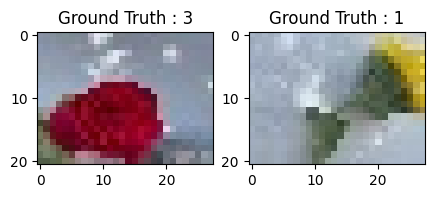

In [12]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
plt.imshow(train_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(train_Y[0]))

# Display the first image in testing data
plt.subplot(122)
plt.imshow(test_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(test_Y[0]))

# Preprocesamos las imagenes

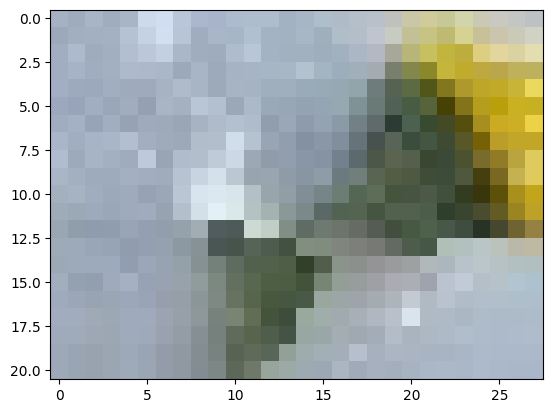

In [13]:
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
train_X = train_X/255.
test_X = test_X/255.
plt.imshow(test_X[0,:,:])

## Hacemos el One-hot Encoding para la red

In [14]:
# Change the labels from categorical to one-hot encoding
train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)

# Display the change for category label using one-hot encoding
print('Original label:', train_Y[0])
print('After conversion to one-hot:', train_Y_one_hot[0])

Original label: 3
After conversion to one-hot: [0. 0. 0. 1. 0.]


# Creamos el Set de Entrenamiento y Validación

In [15]:
#Mezclar todo y crear los grupos de entrenamiento y testing
train_X,valid_X,train_label,valid_label = train_test_split(train_X, train_Y_one_hot, test_size=0.2, random_state=13)

In [16]:
print(train_X.shape,valid_X.shape,train_label.shape,valid_label.shape)

(12373, 21, 28, 3) (3094, 21, 28, 3) (12373, 5) (3094, 5)


# Creamos el modelo de CNN

In [17]:
#declaramos variables con los parámetros de configuración de la red
INIT_LR = 1e-3 # Valor inicial de learning rate. El valor 1e-3 corresponde con 0.001
epochs = 50 # Cantidad de iteraciones completas al conjunto de imagenes de entrenamiento
batch_size = 64 # cantidad de imágenes que se toman a la vez en memoria

In [18]:
flowers_model = Sequential()
flowers_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',padding='same',input_shape=(21,28,3)))
flowers_model.add(LeakyReLU(alpha=0.1))
flowers_model.add(MaxPooling2D((2, 2),padding='same'))
flowers_model.add(Dropout(0.5))

flowers_model.add(Flatten())
flowers_model.add(Dense(32, activation='linear'))
flowers_model.add(LeakyReLU(alpha=0.1))
flowers_model.add(Dropout(0.5))
flowers_model.add(Dense(nClasses, activation='softmax'))

In [19]:
flowers_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 21, 28, 32)        896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 21, 28, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 11, 14, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 11, 14, 32)        0         
                                                                 
 flatten (Flatten)           (None, 4928)              0         
                                                                 
 dense (Dense)               (None, 32)                157728    
                                                        

In [20]:
flowers_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.legacy.SGD(learning_rate=INIT_LR, decay=INIT_LR / 100),metrics=['accuracy'])

In [141]:
tf.config.experimental_run_functions_eagerly(True)

# Entrenamos el modelo: Aprende a clasificar imágenes

In [21]:
# este paso puede tomar varios minutos, dependiendo de tu ordenador, cpu y memoria ram libre
flowers_train = flowers_model.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))

Epoch 1/50


194/194 [==============================] - 2s 6ms/step - loss: 1.6298 - accuracy: 0.2033 - val_loss: 1.5907 - val_accuracy: 0.3074
Epoch 2/50
194/194 [==============================] - 1s 6ms/step - loss: 1.5978 - accuracy: 0.2379 - val_loss: 1.5737 - val_accuracy: 0.3487
Epoch 3/50
194/194 [==============================] - 1s 6ms/step - loss: 1.5738 - accuracy: 0.2655 - val_loss: 1.5368 - val_accuracy: 0.4047
Epoch 4/50
194/194 [==============================] - 1s 6ms/step - loss: 1.5516 - accuracy: 0.2907 - val_loss: 1.4987 - val_accuracy: 0.4803
Epoch 5/50
194/194 [==============================] - 1s 6ms/step - loss: 1.5236 - accuracy: 0.3142 - val_loss: 1.4538 - val_accuracy: 0.5171
Epoch 6/50
194/194 [==============================] - 1s 6ms/step - loss: 1.4926 - accuracy: 0.3422 - val_loss: 1.4090 - val_accuracy: 0.5656
Epoch 7/50
194/194 [==============================] - 1s 6ms/step - loss: 1.4573 - accuracy: 0.3791 - val_loss: 1.3585 - val_accuracy: 0.5966
Epoc

In [22]:
# guardamos la red, para reutilizarla en el futuro, sin tener que volver a entrenar
flowers_model.save("C:\\Users\\Edani\\OneDrive\\Documentos\\IA\\CNN\\flowers.h5py")

INFO:tensorflow:Assets written to: C:\Users\Edani\OneDrive\Documentos\IA\CNN\flowers.h5py\assets


INFO:tensorflow:Assets written to: C:\Users\Edani\OneDrive\Documentos\IA\CNN\flowers.h5py\assets


# Evaluamos la red

In [23]:
test_eval = flowers_model.evaluate(test_X, test_Y_one_hot, verbose=1)

121/121 [==============================] - 0s 2ms/step - loss: 0.5938 - accuracy: 0.8288


In [24]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.5937550067901611
Test accuracy: 0.8288078904151917


In [25]:
flowers_train.history

{'loss': [1.6298147439956665,
  1.597822666168213,
  1.5738321542739868,
  1.5516051054000854,
  1.5235555171966553,
  1.492586612701416,
  1.457345724105835,
  1.4175246953964233,
  1.3775984048843384,
  1.3428926467895508,
  1.299078106880188,
  1.2646150588989258,
  1.2460463047027588,
  1.2169837951660156,
  1.1857401132583618,
  1.1704508066177368,
  1.138004183769226,
  1.1097155809402466,
  1.0906254053115845,
  1.0701543092727661,
  1.0486797094345093,
  1.0435770750045776,
  1.0111572742462158,
  0.9965417981147766,
  0.9786836504936218,
  0.9674124121665955,
  0.9510966539382935,
  0.9408881068229675,
  0.9213586449623108,
  0.9142171740531921,
  0.9064880609512329,
  0.8833009600639343,
  0.8774697184562683,
  0.8699952960014343,
  0.860511839389801,
  0.8481295108795166,
  0.8328111171722412,
  0.830421507358551,
  0.8129080533981323,
  0.8122119903564453,
  0.804817795753479,
  0.8033179640769958,
  0.7876924276351929,
  0.7818813323974609,
  0.7791407704353333,
  0.776826

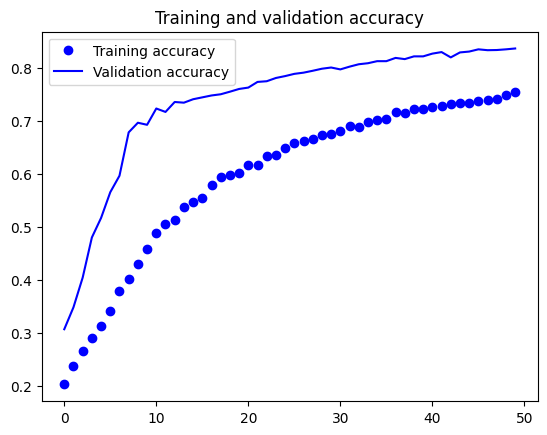

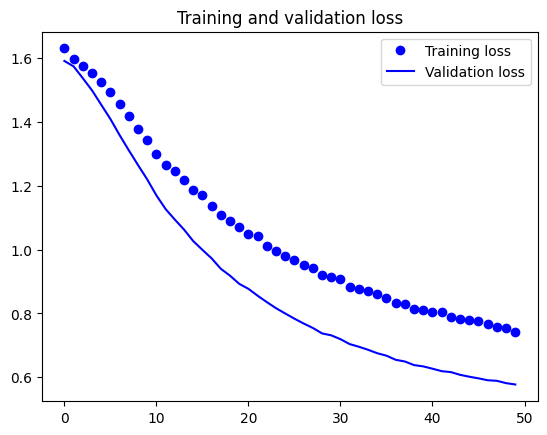

In [26]:
accuracy = flowers_train.history['accuracy']
val_accuracy = flowers_train.history['val_accuracy']
loss = flowers_train.history['loss']
val_loss = flowers_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [28]:
predicted_classes2 = flowers_model.predict(test_X)

121/121 [==============================] - 0s 2ms/step


In [29]:
predicted_classes=[]
for predicted_flores in predicted_classes2:
    predicted_classes.append(predicted_flores.tolist().index(max(predicted_flores)))
predicted_classes=np.array(predicted_classes)

In [30]:
predicted_classes.shape, test_Y.shape

((3867,), (3867,))

# Aprendamos de los errores: Qué mejorar

Found 3205 correct labels


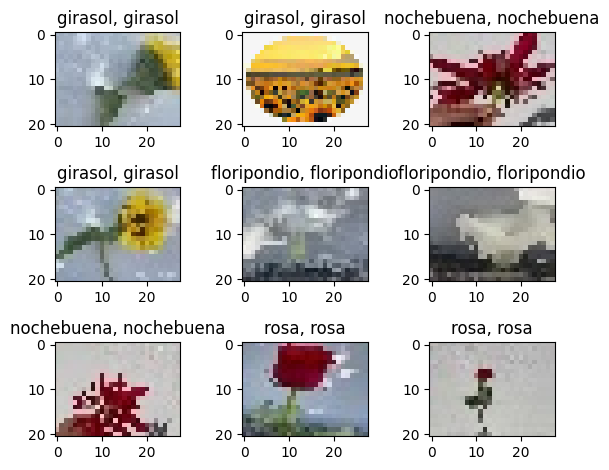

In [31]:
correct = np.where(predicted_classes==test_Y)[0]
print("Found %d correct labels" % len(correct))
for i, correct in enumerate(correct[0:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[correct].reshape(21,28,3), cmap='gray', interpolation='none')
    plt.title("{}, {}".format(flores[predicted_classes[correct]],
                                                    flores[test_Y[correct]]))

    plt.tight_layout()

Found 662 incorrect labels


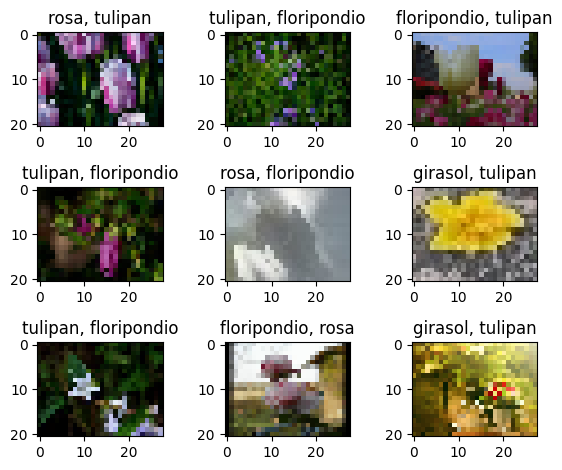

In [32]:
incorrect = np.where(predicted_classes!=test_Y)[0]
print("Found %d incorrect labels" % len(incorrect))
for i, incorrect in enumerate(incorrect[0:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[incorrect].reshape(21,28,3), cmap='gray', interpolation='none')
    plt.title("{}, {}".format(flores[predicted_classes[incorrect]],
                                                    flores[test_Y[incorrect]]))
    plt.tight_layout()

In [33]:
target_names = ["Class {}".format(i) for i in range(nClasses)]
print(classification_report(test_Y, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.79      0.86      0.82       688
     Class 1       0.88      0.88      0.88       842
     Class 2       0.86      0.93      0.89       609
     Class 3       0.83      0.77      0.80       884
     Class 4       0.79      0.74      0.76       844

    accuracy                           0.83      3867
   macro avg       0.83      0.84      0.83      3867
weighted avg       0.83      0.83      0.83      3867



# PROBANDO LA RED CONVOLUSIONAL

In [1]:
# Cargar la imagen con OpenCV
img = cv2.imread('prueba.jpg')
img = cv2.resize(img, (28, 21))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_array = np.array(img)
img_array = np.expand_dims(img_array, axis=0)

img_array = img_array.astype('float32')
img_array = img_array / 255.

# Realizar la predicción
predicted_class = flowers_model.predict(img_array)
clase_predicha = np.argmax(predicted_class)

# Obtener el nombre de la clase predicha (asumiendo que tienes un diccionario class_names) # Reemplaza con tu diccionario
nombre_clase_predicha = flores[clase_predicha]

# Mostrar la imagen con el nombre de la clase predicha
plt.imshow(img_array[0, :, :])
plt.title(nombre_clase_predicha, fontsize=12)
plt.show()

NameError: name 'cv2' is not defined